In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, f1_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
from scipy import stats
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_predict

In [2]:
#Read data from file
df=pd.read_excel('Course Project - Data for Classification - Electric Vehicles.xls')

In [3]:
# Replace non-numeric values with NaN
df.replace('?', np.nan, inplace=True)

In [4]:
#fill null values with median
#Our target column
target_column_name = 'Q16'
target_column_exclude = df[target_column_name]

columns_to_impute = df.drop(columns=[target_column_name])

imputed_data_wo_target = columns_to_impute.fillna(columns_to_impute.median())

imputed_df = pd.concat([imputed_data_wo_target, target_column_exclude], axis=1)

In [5]:
print(f"Imputed data shape: {imputed_df.shape}")

Imputed data shape: (6108, 75)


In [6]:
 # Copy the DataFrame to avoid modifying the original
imputed_df_copy = imputed_df.copy()

X = imputed_df_copy.drop(columns=[target_column_name])
y = imputed_df_copy[target_column_name]

mutual_info_values = mutual_info_classif(X, y)

feature_mutual_info = pd.Series(mutual_info_values, index=X.columns)

ranked_features = feature_mutual_info.sort_values(ascending=False)

# Select features based on the mutual information threshold which is zero
selected_features = feature_mutual_info[feature_mutual_info > 0].index.tolist()

print("Selected Features and Mutual Information Scores:")
for feature in selected_features:
    print(f"{feature}:      {feature_mutual_info[feature]}")


print

Selected Features and Mutual Information Scores:
Q11_1:      0.001205259204720921
Q11_3:      0.012854802490310568
Q11_4:      0.015682212257930317
Q11_5:      0.018166350732367054
Q11_6:      0.015082365829664823
Q11_9:      0.010130614048772912
Q11_10:      0.002484707033594713
Q11_11:      0.012126022396137248
Q11_12:      0.007600871859722691
Q11_13:      0.0055990203418780915
Q11_Dont_Know:      0.027574154854617117
Q12_1:      0.047386020456040345
Q12_2:      0.018407108798150773
Q12_3:      0.018748530288067222
Q12_4:      0.04368847931329656
Q12_5:      0.012508875275370368
Q12_6:      0.019732153903722516
Q12_7:      0.012847945591378362
Q12_9:      0.011961548838672176
Q12_10:      0.02591026825527054
Q12_11:      0.01564437211421188
Q12_12:      0.0017343150877788815
Q12_13:      0.006162570043026783
Q12_14:      0.11367748346404216
Q12_Dont_Know:      0.03971631622766214
Q13_1:      0.021800949943910464
Q13_2:      0.055647874903090866
Q13_3:      0.03545481843240106
Q13_4:

In [7]:
#keep only the selected features in dataframe
imputed_df_Minfo = imputed_df.loc[:, selected_features + ['Q16']]
print(imputed_df_Minfo.head())

   Q11_1  Q11_3  Q11_4  Q11_5  Q11_6  Q11_9  Q11_10  Q11_11  Q11_12  Q11_13  \
0      0      0      1      1      0      0       0       1       0       0   
1      1      0      1      0      0      0       1       0       0       0   
2      1      0      1      0      0      0       1       0       0       0   
3      0      0      0      0      0      0       0       0       0       0   
4      1      0      1      0      0      0       1       1       0       0   

   ...  Q18_17  Q18_18  Q18_19  Q18_20  Q18_21  Q18_22  Q18_23  Q20  Q21  Q16  
0  ...     5.0     5.0     5.0     5.0     5.0     5.0     5.0    3    3    A  
1  ...     4.0     2.0     4.0     2.0     2.0     2.0     2.0    3    3    D  
2  ...     4.0     4.0     3.0     2.0     4.0     2.0     4.0    4    1    A  
3  ...     3.0     2.0     3.0     2.0     3.0     2.0     2.0    3    3    C  
4  ...     3.0     2.0     1.0     1.0     3.0     2.0     2.0    3    3    D  

[5 rows x 69 columns]


In [8]:
imputed_df_Minfo_multiclass = imputed_df_Minfo.copy()
#replace str values to int values for easier calculation
imputed_df_Minfo_multiclass['Q16'] =imputed_df_Minfo_multiclass['Q16'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3})
imputed_df_Minfo_multiclass['Q16'].value_counts() 

Q16
0    2883
1    1526
2     892
3     807
Name: count, dtype: int64

In [9]:
#oversample the data to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(imputed_df_Minfo_multiclass.drop(columns=['Q16']), imputed_df_Minfo_multiclass['Q16'])
imputed_df_Minfo_multiclass_resampled = pd.concat([pd.DataFrame(X_resampled, columns=imputed_df_Minfo_multiclass.drop(columns=['Q16']).columns), pd.Series(y_resampled, name='Q16')], axis=1)
print(f"Imputed resampled multiclass data shape: {imputed_df_Minfo_multiclass_resampled.shape}")

X = imputed_df_Minfo_multiclass_resampled.drop(columns=['Q16'])
y = imputed_df_Minfo_multiclass_resampled['Q16']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Imputed resampled multiclass data shape: (11532, 69)


In [10]:
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)
gaussian_nb = GaussianNB()
adaboost = AdaBoostClassifier(random_state=42)
print("imputed_df_Minfo_multiclass_resampled accuracy Scores:")
classifiers = {
    'Decision Tree': decision_tree,
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'Gaussian Naive Bayes': gaussian_nb,
    'AdaBoost': adaboost
}

for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    avg_accuracy = scores.mean()
    print(f"{clf_name} Accuracy: {avg_accuracy:.4f}")

imputed_df_Minfo_multiclass_resampled accuracy Scores:
Decision Tree Accuracy: 0.7979
Random Forest Accuracy: 0.8529
Gradient Boosting Accuracy: 0.6758
Gaussian Naive Bayes Accuracy: 0.5604
AdaBoost Accuracy: 0.5949


In [11]:
# Models that work best with a scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("imputed_df_Minfo_multiclass_resampled accuracy Scores for models with scaling:")

knn = KNeighborsClassifier()
svm = SVC()
mlp = MLPClassifier(max_iter=1000, solver='adam', learning_rate_init=0.001, tol=1e-4)
logistic = LogisticRegression(max_iter=1000)
sgd = SGDClassifier(max_iter=1000, tol=1e-4)

classifiers = {
    'KNN': knn,
    'SVM': svm,
    'Neural Network': mlp,
    'Logistic Regression': logistic,
    'SGD': sgd
}

for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    avg_accuracy = scores.mean()
    print(f"{clf_name} Accuracy: {avg_accuracy:.4f}")

imputed_df_Minfo_multiclass_resampled accuracy Scores for models with scaling:
KNN Accuracy: 0.6278
SVM Accuracy: 0.6401
Neural Network Accuracy: 0.8002
Logistic Regression Accuracy: 0.6104
SGD Accuracy: 0.5535


imputed_df_Minfo_multiclass_resampled five fold accuracy score for highest accuracy:
Random Forest - Fold 1: Accuracy = 0.8838
Random Forest - Fold 2: Accuracy = 0.8830
Random Forest - Fold 3: Accuracy = 0.8855
Random Forest - Fold 4: Accuracy = 0.8781
Random Forest - Fold 5: Accuracy = 0.8842
Random Forest - Mean Accuracy: 0.8829
Accuracy: 0.8838318162115302
Confusion Matrix:
[[460  85  13  32]
 [ 58 474  12  18]
 [  1   9 540  13]
 [ 15   6   6 565]]


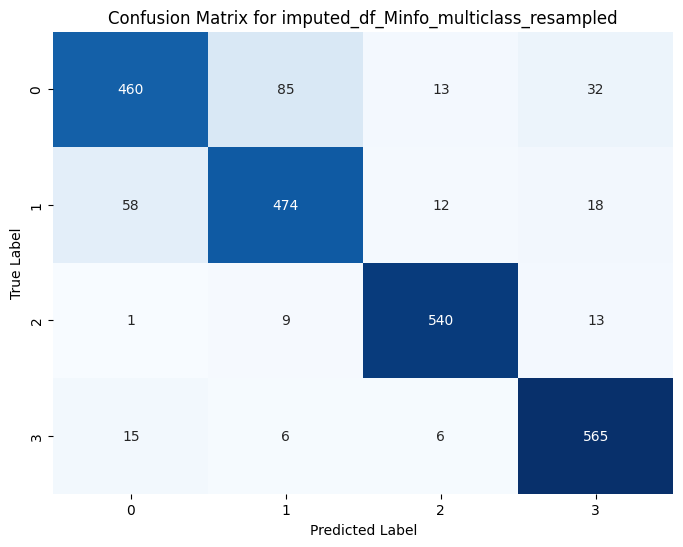

In [12]:
num_folds = 5
print("imputed_df_Minfo_multiclass_resampled five fold accuracy score for highest accuracy:")
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

rf_classifier = RandomForestClassifier()

accuracy_scores = cross_val_score(rf_classifier, X, y, cv=cv, scoring='accuracy')

for i, accuracy in enumerate(accuracy_scores, start=1):
    print(f'Random Forest - Fold {i}: Accuracy = {accuracy:.4f}')

mean_accuracy = accuracy_scores.mean()
print(f'Random Forest - Mean Accuracy: {mean_accuracy:.4f}')

random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.title("Confusion Matrix for imputed_df_Minfo_multiclass_resampled")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [13]:
imputed_df_Minfo_binaryclass = imputed_df.copy()

imputed_df_Minfo_binaryclass['Q16'] = imputed_df_Minfo_binaryclass['Q16'].replace({'A': 0, 'B': 1, 'C': 1, 'D': 1})
print(imputed_df_Minfo_binaryclass['Q16'].value_counts())


Q16
1    3225
0    2883
Name: count, dtype: int64


In [14]:
#oversample the data by 10%
ros = RandomOverSampler(sampling_strategy={0: 3360, 1:3360},random_state=42)
X_resampled_10, y_resampled_10 = ros.fit_resample(imputed_df_Minfo_binaryclass.drop(columns=['Q16']), imputed_df_Minfo_binaryclass['Q16'])
imputed_df_Minfo_binaryclass_resampled_10 = pd.concat([pd.DataFrame(X_resampled_10, columns=imputed_df_Minfo_binaryclass.drop(columns=['Q16']).columns), pd.Series(y_resampled_10, name='Q16')], axis=1)

print(f"Imputed data shape: {imputed_df_Minfo_binaryclass_resampled_10.shape}")

imputed_df_Minfo_binaryclass_resampled_10['Q16'].value_counts() 

X = imputed_df_Minfo_binaryclass_resampled_10.drop(columns=['Q16'])
y = imputed_df_Minfo_binaryclass_resampled_10['Q16']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Imputed data shape: (6720, 75)


In [15]:
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier()
gaussian_nb = GaussianNB()
adaboost = AdaBoostClassifier(random_state=42)
print("imputed_df_Minfo_binaryclass_resampled_10 accuracy Scores:")
classifiers = {
    'Decision Tree': decision_tree,
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'Gaussian Naive Bayes': gaussian_nb,
    'AdaBoost': adaboost
}

for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    avg_accuracy = scores.mean()
    print(f"{clf_name} Accuracy: {avg_accuracy:.4f}")

imputed_df_Minfo_binaryclass_resampled_10 accuracy Scores:
Decision Tree Accuracy: 0.7042
Random Forest Accuracy: 0.7818
Gradient Boosting Accuracy: 0.7690
Gaussian Naive Bayes Accuracy: 0.6933
AdaBoost Accuracy: 0.7550


In [16]:
# models that work best with a scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("imputed_df_Minfo_binaryclass_resampled_10 accuracy Scores for scaling models:")

knn = KNeighborsClassifier()
svm = SVC()
mlp = MLPClassifier(max_iter=1000, solver='adam', learning_rate_init=0.001, tol=1e-4)
logistic = LogisticRegression(max_iter=1000)
sgd = SGDClassifier(max_iter=1000, tol=1e-4)

classifiers = {
    'KNN': knn,
    'SVM': svm,
    'Neural Network': mlp,
    'Logistic Regression': logistic,
    'SGD': sgd
}

for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
    avg_accuracy = scores.mean()
    print(f"{clf_name} Accuracy: {avg_accuracy:.4f}")

imputed_df_Minfo_binaryclass_resampled_10 accuracy Scores for scaling models:
KNN Accuracy: 0.6894
SVM Accuracy: 0.7710
Neural Network Accuracy: 0.7347
Logistic Regression Accuracy: 0.7625
SGD Accuracy: 0.7442


imputed_df_Minfo_binaryclass_resampled_10 five fold accuracy with highest accuracy model:
Random Forest - Fold 1: Accuracy = 0.7812
Random Forest - Fold 2: Accuracy = 0.7812
Random Forest - Fold 3: Accuracy = 0.7954
Random Forest - Fold 4: Accuracy = 0.7872
Random Forest - Fold 5: Accuracy = 0.7991
Random Forest - Mean Accuracy: 0.7888
Accuracy: 0.7901785714285714
Confusion Matrix:
[[549 118]
 [164 513]]


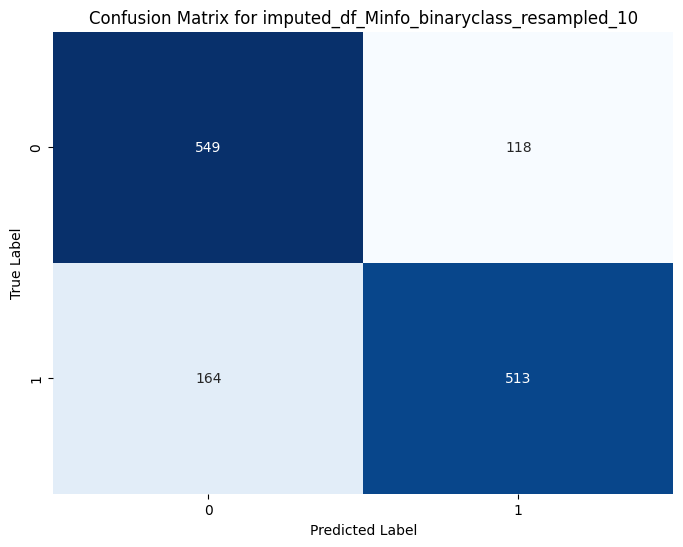

In [17]:
num_folds = 5
print("imputed_df_Minfo_binaryclass_resampled_10 five fold accuracy with highest accuracy model:")
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

rf_classifier = RandomForestClassifier()
accuracy_scores = cross_val_score(rf_classifier, X, y, cv=cv, scoring='accuracy')

for i, accuracy in enumerate(accuracy_scores, start=1):
    print(f'Random Forest - Fold {i}: Accuracy = {accuracy:.4f}')

mean_accuracy = accuracy_scores.mean()
print(f'Random Forest - Mean Accuracy: {mean_accuracy:.4f}')

random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.title("Confusion Matrix for imputed_df_Minfo_binaryclass_resampled_10")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

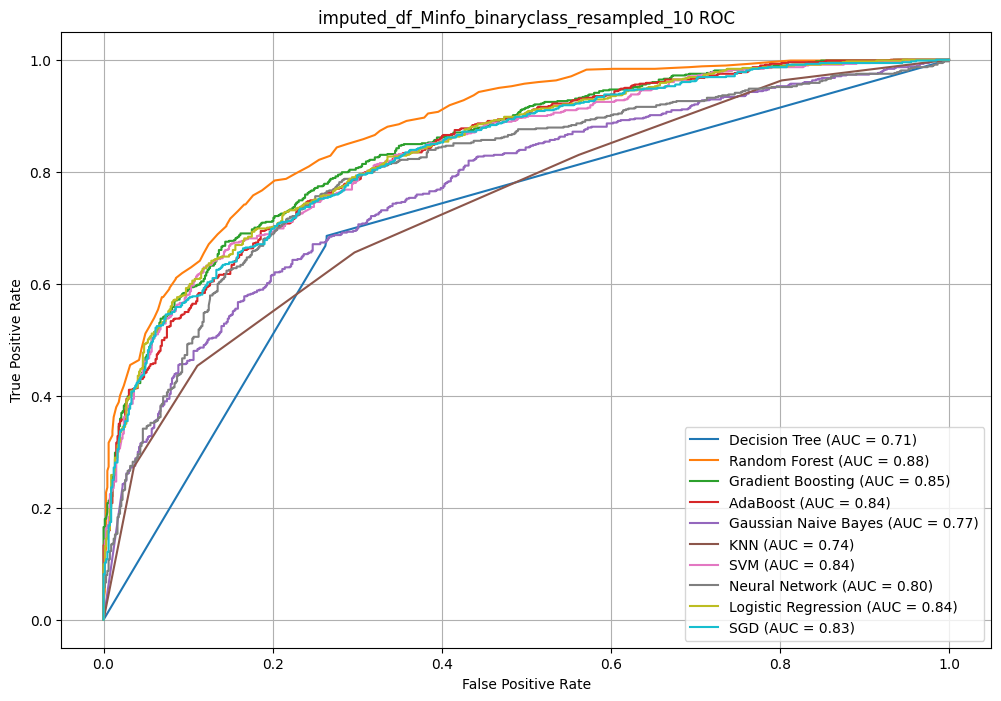

In [18]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(C=1.0, kernel='linear', probability=True),  # Set probability to True
    'Neural Network': MLPClassifier(max_iter=2000, solver='adam', alpha=0.0001),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'SGD': SGDClassifier()
}

plt.figure(figsize=(12, 8))

for clf_name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    
    
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test_scaled)[:, 1]
    else:
        
        y_scores = clf.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.title('imputed_df_Minfo_binaryclass_resampled_10 ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [19]:
print("imputed_df_Minfo_binaryclass_resampled_10 metrics: ")
metrics = {
    'AUC': make_scorer(roc_auc_score),
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'MCC': make_scorer(matthews_corrcoef)
}

# Combine all classifiers into a single dictionary
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(C=1.0, kernel='linear'),
    'Neural Network': MLPClassifier(max_iter=2000, solver='adam', alpha=0.0001),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'SGD': SGDClassifier()
}


for clf_name, clf in classifiers.items():
    print(f"\nMetrics for {clf_name}:\n")
    
    for metric_name, scorer in metrics.items():
        scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring=scorer)
        avg_metric = scores.mean()
        print(f"{metric_name}: {avg_metric:.4f}")

imputed_df_Minfo_binaryclass_resampled_10 metrics: 

Metrics for Decision Tree:

AUC: 0.7042
F1: 0.6999
Precision: 0.7088
Recall: 0.6914
MCC: 0.4087

Metrics for Random Forest:

AUC: 0.7818
F1: 0.7747
Precision: 0.7988
Recall: 0.7525
MCC: 0.5648

Metrics for Gradient Boosting:

AUC: 0.7689
F1: 0.7653
Precision: 0.7762
Recall: 0.7551
MCC: 0.5384

Metrics for AdaBoost:

AUC: 0.7550
F1: 0.7495
Precision: 0.7657
Recall: 0.7343
MCC: 0.5107

Metrics for Gaussian Naive Bayes:

AUC: 0.6930
F1: 0.6457
Precision: 0.7625
Recall: 0.5602
MCC: 0.4007

Metrics for KNN:

AUC: 0.6893
F1: 0.6798
Precision: 0.7005
Recall: 0.6605
MCC: 0.3794

Metrics for SVM:

AUC: 0.7641
F1: 0.7552
Precision: 0.7836
Recall: 0.7290
MCC: 0.5296

Metrics for Neural Network:

AUC: 0.7301
F1: 0.7344
Precision: 0.7407
Recall: 0.7205
MCC: 0.4781

Metrics for Logistic Regression:

AUC: 0.7624
F1: 0.7552
Precision: 0.7777
Recall: 0.7343
MCC: 0.5258

Metrics for SGD:

AUC: 0.7374
F1: 0.7393
Precision: 0.7813
Recall: 0.6876
MCC: 0.

In [20]:
ros = RandomOverSampler(sampling_strategy={0: 3664, 1:3664},random_state=42)
X_resampled_20, y_resampled_20 = ros.fit_resample(imputed_df_Minfo_binaryclass.drop(columns=['Q16']), imputed_df_Minfo_binaryclass['Q16'])
imputed_df_Minfo_binaryclass_resampled_20 = pd.concat([pd.DataFrame(X_resampled_20, columns=imputed_df_Minfo_binaryclass.drop(columns=['Q16']).columns), pd.Series(y_resampled_20, name='Q16')], axis=1)
#oversample the data by 20%
print(f"Imputed data shape: {imputed_df_Minfo_binaryclass_resampled_20.shape}")

imputed_df_Minfo_binaryclass_resampled_20['Q16'].value_counts() 


X = imputed_df_Minfo_binaryclass_resampled_20.drop(columns=['Q16'])
y = imputed_df_Minfo_binaryclass_resampled_20['Q16']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Imputed data shape: (7328, 75)


In [21]:
excel_file_path = 'FEZ– CENG464 Project - Data.xlsx'

with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    imputed_df_Minfo_multiclass_resampled.to_excel(writer, sheet_name='multiclass_resampled', index=False)
    imputed_df_Minfo_binaryclass_resampled_10.to_excel(writer, sheet_name='binaryclass_resampled_10', index=False)
    imputed_df_Minfo_binaryclass_resampled_20.to_excel(writer, sheet_name='binaryclass_resampled_20', index=False)

In [22]:
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier()
gaussian_nb = GaussianNB()
adaboost = AdaBoostClassifier(random_state=42)
print("imputed_df_Minfo_binaryclass_resampled_20 accuracy scores: ")
classifiers = {
    'Decision Tree': decision_tree,
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'Gaussian Naive Bayes': gaussian_nb,
    'AdaBoost': adaboost
}


for clf_name, clf in classifiers.items():
    
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    avg_accuracy = scores.mean()
    print(f"{clf_name} Accuracy: {avg_accuracy:.4f}")

imputed_df_Minfo_binaryclass_resampled_20 accuracy scores: 
Decision Tree Accuracy: 0.7480
Random Forest Accuracy: 0.8129
Gradient Boosting Accuracy: 0.7757
Gaussian Naive Bayes Accuracy: 0.6945
AdaBoost Accuracy: 0.7612


In [23]:
# models that work best with scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("imputed_df_Minfo_binaryclass_resampled_20 accuracy scores for scaling models: ")

knn = KNeighborsClassifier()
svm = SVC()
mlp = MLPClassifier(max_iter=1000, solver='adam', learning_rate_init=0.001, tol=1e-4)
logistic = LogisticRegression(max_iter=1000)
sgd = SGDClassifier(max_iter=1000, tol=1e-4)

classifiers = {
    'KNN': knn,
    'SVM': svm,
    'Neural Network': mlp,
    'Logistic Regression': logistic,
    'SGD': sgd
}

for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
    avg_accuracy = scores.mean()
    print(f"{clf_name} Accuracy: {avg_accuracy:.4f}")

imputed_df_Minfo_binaryclass_resampled_20 accuracy scores for scaling models: 
KNN Accuracy: 0.6916
SVM Accuracy: 0.7873
Neural Network Accuracy: 0.7718
Logistic Regression Accuracy: 0.7646
SGD Accuracy: 0.7530


imputed_df_Minfo_binaryclass_resampled_20 five fold for highest accuracy model: 
Random Forest - Fold 1: Accuracy = 0.8056
Random Forest - Fold 2: Accuracy = 0.8295
Random Forest - Fold 3: Accuracy = 0.8138
Random Forest - Fold 4: Accuracy = 0.8109
Random Forest - Fold 5: Accuracy = 0.8116
Random Forest - Mean Accuracy: 0.8143
Accuracy: 0.8124147339699863
Confusion Matrix:
[[615 116]
 [159 576]]


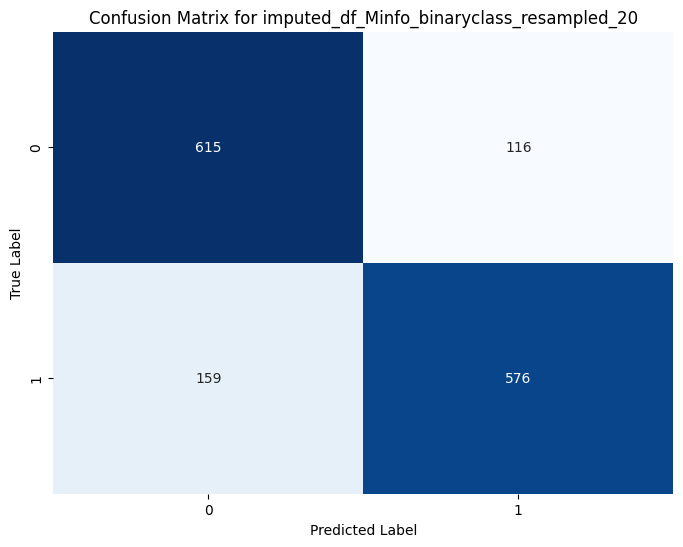

In [24]:
num_folds = 5
print("imputed_df_Minfo_binaryclass_resampled_20 five fold for highest accuracy model: ")

cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

rf_classifier = RandomForestClassifier()

accuracy_scores = cross_val_score(rf_classifier, X, y, cv=cv, scoring='accuracy')

for i, accuracy in enumerate(accuracy_scores, start=1):
    print(f'Random Forest - Fold {i}: Accuracy = {accuracy:.4f}')

mean_accuracy = accuracy_scores.mean()
print(f'Random Forest - Mean Accuracy: {mean_accuracy:.4f}')

random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.title("Confusion Matrix for imputed_df_Minfo_binaryclass_resampled_20")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

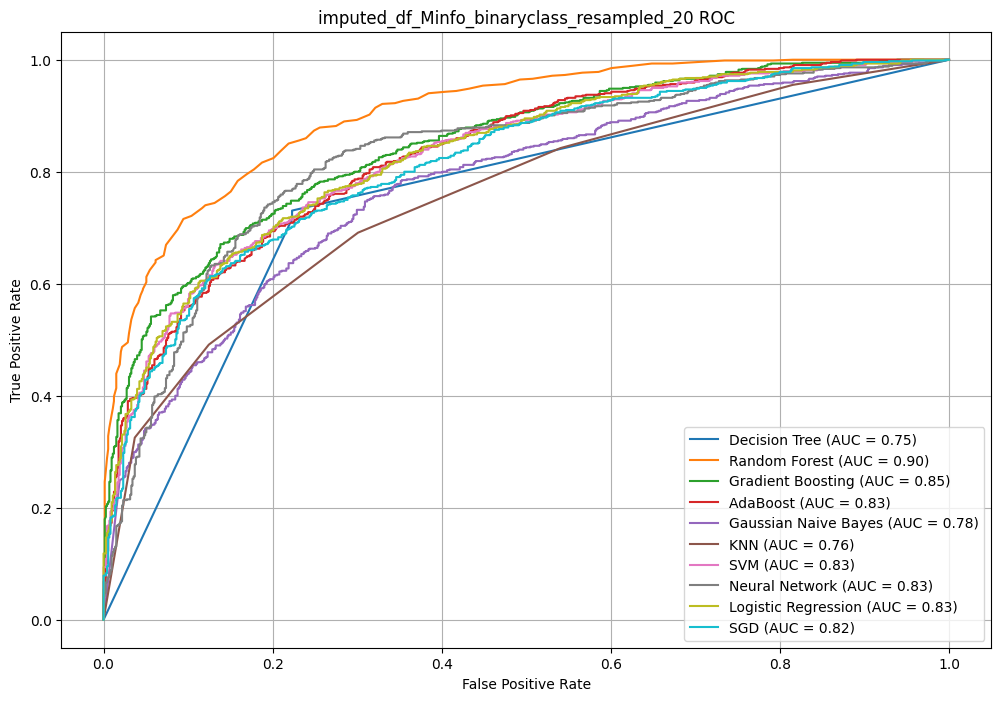

In [25]:

classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(C=1.0, kernel='linear', probability=True),  # Set probability to True
    'Neural Network': MLPClassifier(max_iter=2000, solver='adam', alpha=0.0001),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'SGD': SGDClassifier()
}


plt.figure(figsize=(12, 8))

for clf_name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test_scaled)[:, 1]
    else:
        y_scores = clf.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')
plt.title('imputed_df_Minfo_binaryclass_resampled_20 ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [26]:
print("imputed_df_Minfo_binaryclass_resampled_20 metrics:")

metrics = {
    'AUC': make_scorer(roc_auc_score),
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'MCC': make_scorer(matthews_corrcoef)
}

classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(C=1.0, kernel='linear'),
    'Neural Network': MLPClassifier(max_iter=2000, solver='adam', alpha=0.0001),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'SGD': SGDClassifier()
}

for clf_name, clf in classifiers.items():
    print(f"\nMetrics for {clf_name}:\n")
    
    for metric_name, scorer in metrics.items():
        scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring=scorer)
        avg_metric = scores.mean()
        print(f"{metric_name}: {avg_metric:.4f}")

imputed_df_Minfo_binaryclass_resampled_20 metrics:

Metrics for Decision Tree:

AUC: 0.7480
F1: 0.7442
Precision: 0.7559
Recall: 0.7334
MCC: 0.4966

Metrics for Random Forest:

AUC: 0.8128
F1: 0.8076
Precision: 0.8306
Recall: 0.7863
MCC: 0.6269

Metrics for Gradient Boosting:

AUC: 0.7757
F1: 0.7728
Precision: 0.7823
Recall: 0.7637
MCC: 0.5516

Metrics for AdaBoost:

AUC: 0.7612
F1: 0.7584
Precision: 0.7670
Recall: 0.7501
MCC: 0.5226

Metrics for Gaussian Naive Bayes:

AUC: 0.6944
F1: 0.6512
Precision: 0.7577
Recall: 0.5712
MCC: 0.4012

Metrics for KNN:

AUC: 0.6916
F1: 0.6833
Precision: 0.7018
Recall: 0.6658
MCC: 0.3836

Metrics for SVM:

AUC: 0.7634
F1: 0.7550
Precision: 0.7822
Recall: 0.7296
MCC: 0.5280

Metrics for Neural Network:

AUC: 0.7724
F1: 0.7763
Precision: 0.7702
Recall: 0.7685
MCC: 0.5359

Metrics for Logistic Regression:

AUC: 0.7646
F1: 0.7581
Precision: 0.7792
Recall: 0.7381
MCC: 0.5299

Metrics for SGD:

AUC: 0.7442
F1: 0.7475
Precision: 0.8241
Recall: 0.6938
MCC: 0.5